#Final Project Code Repository


**Team Members:** Michael Amare, Michelle Wan, Priya Verma  
**Course:** DS 703 - Advanced Machine Learning  
**Date:** December 3 2025  

**Purpose:**  
This notebook presents the complete end-to-end machine learning pipeline for our Food-101 classification project, including preprocessing, model selection, retraining, and final evaluation.


#A.1 - Setup & Context

This project was completed in two milestones. In Milestone 1, the team selected the Food-101 dataset containing 101,000 images across 101 balanced food categories. Some challenges that we identified included: variable image quality, visually similar classes, and raw data that required preprocessing. We cleaned the data by converting images to RGB, resizing to 224×224, normalizing pixels to [0,1], and creating stratified 80/10/10 splits with a fixed seed for reproducibility. Our augmentation strategy included random flips, rotations, and zoom to improve generalization. In Milestone 2, we experimented with three model architectures: a baseline single-layer CNN, Custom Model 1, and Customer Model 2. The baseline and Custom Model 1 models had dysmal results and severely underfit (giving 0.99% accuracy) the data. Custom Model 2 featured four convolutional blocks with progressive filters (32->256), batch normalization, global average pooling, and dropout, and achieved 44% validation accuracy. Transfer learning experiments with EfficientNetB0 (frozen, unfrozen, and partially unfrozen configurations) surprisingly failed despite having 4.4M parameters, leading us to conclude that Custom Model 2's from-scratch architecture was most successful and would serve as our foundation moving forward.

##Loading the Food-101 Dataset

In [ ]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 6.1 MB/s eta 0:00:00


In [ ]:
# ============================================
# Useful Imports
# ============================================

# --- Standard Libraries
import os
import time
import math
import random
from collections import Counter

# --- Core Data / Numerics
import numpy as np
import pandas as pd

# --- Visualization
import matplotlib.pyplot as plt
# import seaborn as sns              # optional
import matplotlib.ticker as mticker  # optional (for formatted axes)

# --- NLP / Tokenization
import spacy                         # used for text preprocessing (HuffPost)

# --- Progress Tracking
from tqdm import tqdm                # optional (nice for loops)

from IPython.display import display

# --- TensorFlow / Keras (Deep Learning)
import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, MaxPooling2D, Conv2D,
    SeparableConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
)
from PIL import UnidentifiedImageError

import imagehash

# --- Hugging Face Datasets
from datasets import load_dataset, DatasetDict
from datasets.features import ClassLabel


# ============================================
# Global Configuration & Small Utilities
# ============================================

# Reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)   # sets Python, NumPy, and TensorFlow seeds

# Utility: format seconds as HH:MM:SS

"""
Example usage to time your code:

start_time = time.time()
# ... your code here ...
print("Execution Time:", format_hms(time.time() - start_time))
"""

def format_hms(seconds: float) -> str:
    """Convert seconds to HH:MM:SS format."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

In [ ]:
food_all = load_dataset("food101", split="train+validation")  # ~101k images total
label_col = "label"

# Sanity check the label column
assert label_col in food_all.features
assert isinstance(food_all.features[label_col], ClassLabel)

food_label_names = food_all.features[label_col].names
print(f"Total images: {len(food_all):,}  |  Classes: {len(food_label_names)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

data/train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

data/validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

Total images: 101,000  |  Classes: 101


Quick sanity checks (rows, label ids, a few image sizes)

In [ ]:
# First 5 rows: label id → name
for i in range(5):
    y = food_all[i][label_col]
    print(f"row {i}: id={y}, name={food_label_names[y]}")

labels_list = list(food_all[label_col])
print("labels length:", len(labels_list), "unique classes:", len(set(labels_list)))
print("min/max label IDs:", min(labels_list), max(labels_list))

for i in range(3):
    print(f"image {i} size:", food_all[i]["image"].size)  # (W, H)

row 0: id=6, name=beignets
row 1: id=6, name=beignets
row 2: id=6, name=beignets
row 3: id=6, name=beignets
row 4: id=6, name=beignets
labels length: 101000 unique classes: 101
min/max label IDs: 0 100
image 0 size: (384, 512)
image 1 size: (512, 512)
image 2 size: (512, 383)


Visual preview: random 3×3 grid from TRAIN

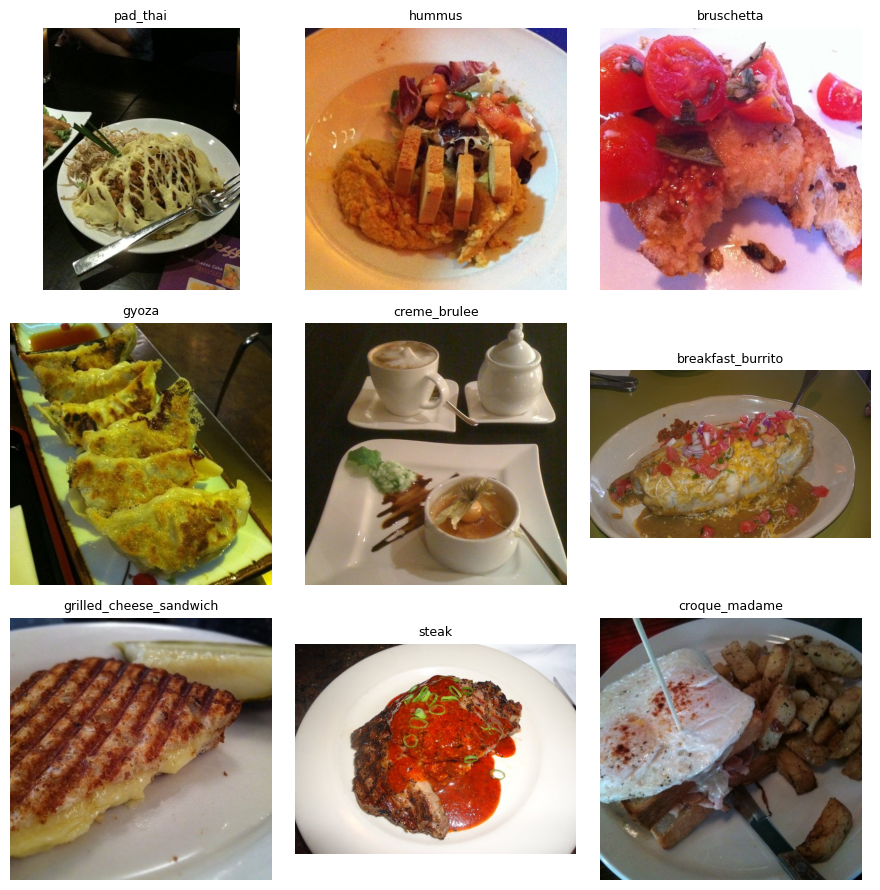

In [ ]:
n, cols, seed = 9, 3, 42
idxs = random.Random(seed).sample(range(len(food_all)), n)
rows = math.ceil(n/cols)

plt.figure(figsize=(3*cols, 3*rows))
for i, idx in enumerate(idxs, 1):
    ex = food_all[idx]
    plt.subplot(rows, cols, i)
    plt.imshow(ex["image"]); plt.axis("off")
    plt.title(food_label_names[ex[label_col]], fontsize=9)
plt.tight_layout(); plt.show()

Total images: 101,000  |  Classes: 101


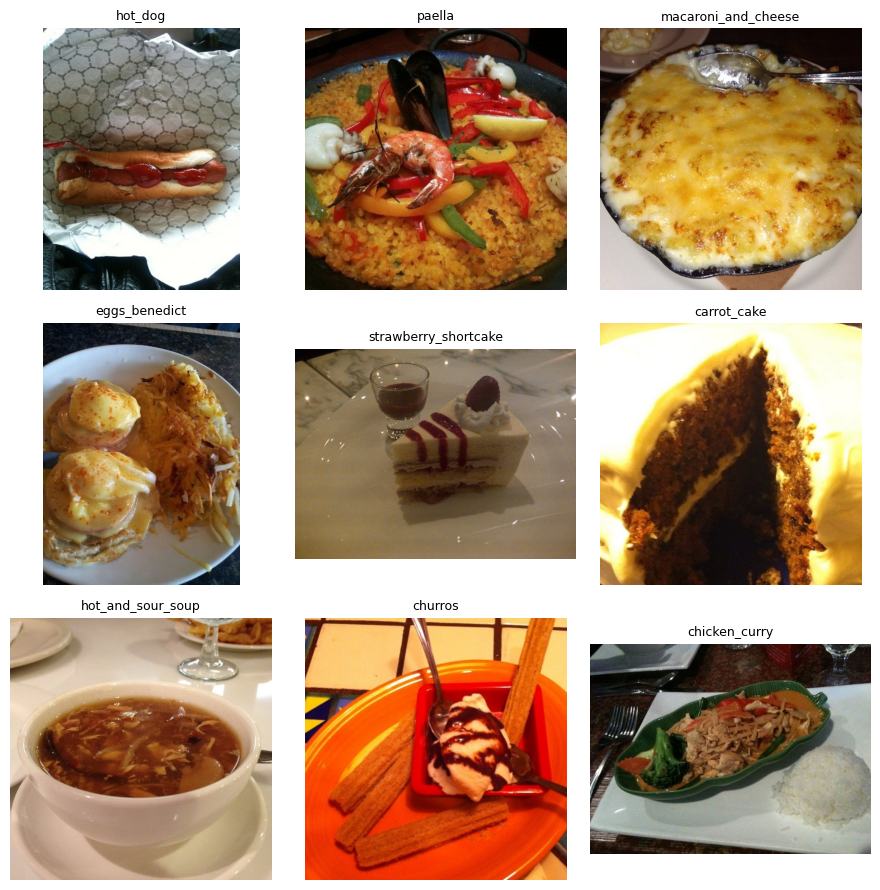

In [ ]:
# Verifying number of samples and classes
print(f"Total images: {len(food_all):,}  |  Classes: {len(food_label_names)}")

# Looking a few samples of images
n, cols, seed = 9, 3, 1
idxs = random.Random(seed).sample(range(len(food_all)), n)
rows = math.ceil(n/cols)

plt.figure(figsize=(3*cols, 3*rows))
for i, idx in enumerate(idxs, 1):
    ex = food_all[idx]
    plt.subplot(rows, cols, i)
    plt.imshow(ex["image"]); plt.axis("off")
    plt.title(food_label_names[ex[label_col]], fontsize=9)
plt.tight_layout(); plt.show()

In [ ]:
print("Number of images: ",len(food_all))
print("Number of class labels: ",len(set(food_label_names)))

Number of images:  101000
Number of class labels:  101


In [ ]:
bad_images = []

for i, ex in enumerate(food_all):
    try:
        ex["image"].verify()    # raise error if the image is unreadable
    except (IOError, UnidentifiedImageError):
        bad_images.append(i)

# Check for duplicates
hashes = [imagehash.average_hash(ex["image"]) for ex in food_all]
duplicates = [h for h, c in Counter(hashes).items() if c > 1]

print("Unreadable images:", len(bad_images))
print("Duplicate hash groups:", len(duplicates))

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Unreadable images: 0
Duplicate hash groups: 186


In [ ]:
print(food_label_names[:20])

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla']


## Data Preparation and Cleaning

In [ ]:
# Defining image size
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

# Generator: converts each image to RGB and skips corrupted ones
def gen():
    for ex in food_all:
        try:
            img = np.array(ex["image"].convert("RGB"))     # ensure RGB
            lbl = ex["label"]
            yield img, lbl
        except:
            pass                                          # drop corrupted files

# Preprocessing: normalize + resize
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # normalize to [0,1]
    image = tf.image.resize(image, IMG_SIZE)                 # resize 224×224
    return image, label

# Build dataset pipeline
tf_ds = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )
)

tf_ds = (tf_ds
         .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
         .batch(BATCH_SIZE)
         .prefetch(tf.data.AUTOTUNE))

# Verify
for images, labels in tf_ds.take(1):
    print("Batch shape:", images.shape)


Exception ignored in: <generator object gen at 0x79ed855aa7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


Batch shape: (64, 224, 224, 3)


In [ ]:
# Confirming images are RGB and resized to 224x224

rgb_resized = 0
total = 0

for images, labels in tf_ds:
    for img in images:
        total += 1
        if img.shape == (224, 224, 3):
            rgb_resized += 1

print(f"{rgb_resized}/{total} images are RGB and resized to 224x224")

101000/101000 images are RGB and resized to 224x224


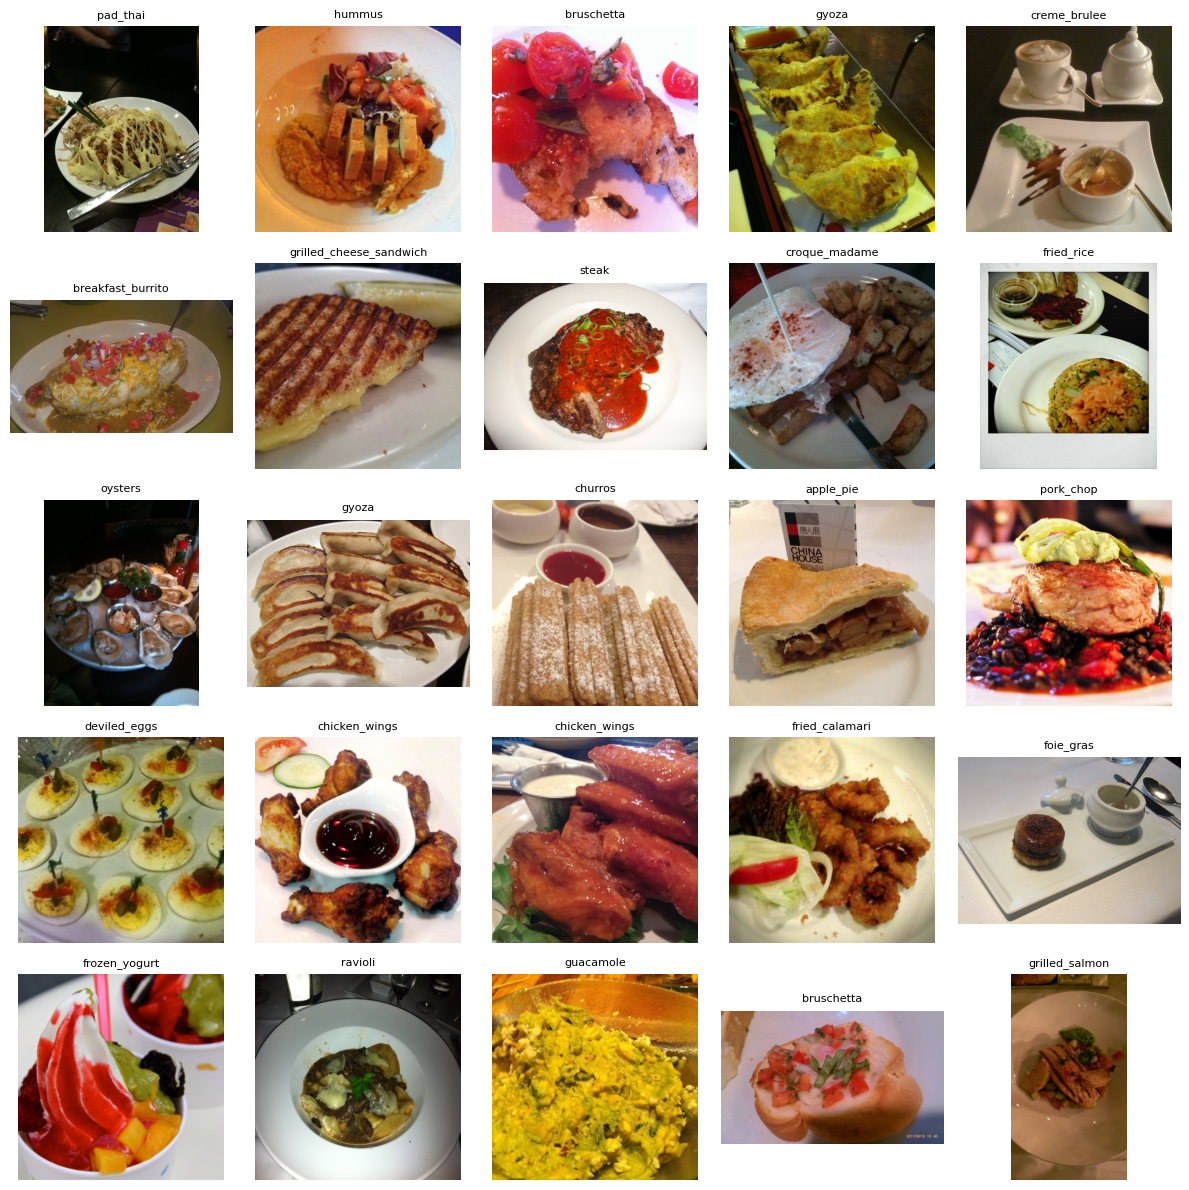

In [ ]:
import matplotlib.pyplot as plt
import random

# Randomly select 25 images to visualize new images
idxs = random.sample(range(len(food_all)), 25)
subset = food_all.select(idxs)
class_names = food_all.features["label"].names

plt.figure(figsize=(12, 12))

for i, ex in enumerate(subset):
    plt.subplot(5, 5, i + 1)
    plt.imshow(ex["image"])
    plt.title(class_names[ex["label"]], fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


###Standardize or Tokenize the inputs

In [ ]:
# Augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.05),
])

# Training dataset with augmentation
train_ds = tf_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Validation dataset (no augmentation)
val_ds = tf_ds

# Verify output
for images, labels in train_ds.take(1):
    print("Batch:", images.shape)
    print("Min pixel:", float(tf.reduce_min(images)))
    print("Max pixel:", float(tf.reduce_max(images)))
    break

Batch: (64, 224, 224, 3)
Min pixel: 0.0
Max pixel: 1.0


Exception ignored in: <generator object gen at 0x79ed855a9210>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


### Handle dataset-specific challenges

In [ ]:
from collections import Counter
import numpy as np
import tensorflow as tf

# Class counts
labels = [ex["label"] for ex in food_all]
label_counts = Counter(labels)

# Class weights
total = sum(label_counts.values())
num_classes = len(label_counts)
class_weights = {cls: total / (num_classes * count) for cls, count in label_counts.items()}

# Verify resizing works
rgb_resized = 0
total_checked = 0
for images, labels in tf_ds.take(20):   # ~1280 samples
    for img in images:
        total_checked += 1
        if img.shape == (224, 224, 3):
            rgb_resized += 1

print(f"{rgb_resized}/{total_checked} images are RGB and 224x224")

# Noise filtering (corrupted + non-food images)
def gen_clean():
    for ex in food_all:
        try:
            img = ex["image"].convert("RGB")   # corrupted images skipped
            yield img, ex["label"]
        except:
            pass


Exception ignored in: <generator object gen at 0x79ed855a9210>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


1280/1280 images are RGB and 224x224


### Create reproducible splits

In [ ]:
from sklearn.model_selection import train_test_split

# labels
labels = [ex["label"] for ex in food_all]

# 80% train, 20% temp
train_idx, temp_idx = train_test_split(
    range(len(food_all)),
    test_size=0.20,
    stratify=labels,
    random_state=42
)

# split temp into 10% val + 10% test
temp_labels = [labels[i] for i in temp_idx]

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.50,     # 50% of temp = 10% of total
    stratify=temp_labels,
    random_state=42
)

# create subsets
train_set = food_all.select(train_idx)
val_set   = food_all.select(val_idx)
test_set  = food_all.select(test_idx)

# print sizes
print("Train size:", len(train_set))
print("Val size:", len(val_set))
print("Test size:", len(test_set))

Train size: 80800
Val size: 10100
Test size: 10100


#A.2 - Model Selection & Retraining

This section builds and trains the final CNN model used for image classification on the Food-101 dataset. First, we prepare the data pipeline by defining a custom generator that loads, resizes, and normalizes each image while safely skipping corrupted samples. We then wrap the generator in TensorFlow Dataset objects to create efficient, batched, prefetched dataloaders for training, validation, and testing. Next, we construct the final model architecture: a four-block convolutional network using He initialization, Batch Normalization, MaxPooling, and Global Average Pooling to control overfitting and stabilize training. A dense layer with dropout is added before the softmax output. The model is compiled with Adam (learning rate 1e-3) and trained for up to 100 epochs with Early Stopping to restore the best weights. Finally, we evaluate test performance to measure true generalization. This code represents the core of the modeling workflow where we implement, train, and validate the best-performing architecture from model selection.

In [ ]:
# Make train, val, and test set into tensorflow

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from PIL import Image

IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

def hf_gen(ds):
    for ex in ds:
        try:
            img = ex["image"].convert("RGB").resize(IMG_SIZE, Image.BILINEAR)
            arr = np.asarray(img, dtype=np.float32) / 255.0
            lbl = int(ex["label"])
            yield arr, lbl
        except GeneratorExit:
            return
        except:
            pass

def make_tf_dataset(ds, batch=32, shuffle=False):
    output_sig = (
        tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )
    tfds = tf.data.Dataset.from_generator(
        lambda: hf_gen(ds),
        output_signature=output_sig
    )
    if shuffle:
        tfds = tfds.shuffle(10_000)
    return tfds.batch(batch).prefetch(AUTOTUNE)

BATCH_SIZE = 64

train_tf = make_tf_dataset(train_set, shuffle=True,  batch=BATCH_SIZE)
val_tf   = make_tf_dataset(val_set,   shuffle=False, batch=BATCH_SIZE)
test_tf  = make_tf_dataset(test_set,  shuffle=False, batch=BATCH_SIZE)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, initializers
from PIL import Image


IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64
num_classes = len(food_label_names)

# Generator
def hf_gen(ds):
    for ex in ds:
        try:
            img = ex["image"].convert("RGB").resize(IMG_SIZE, Image.BILINEAR)
            arr = np.asarray(img, dtype=np.float32) / 255.0
            lbl = int(ex["label"])
            yield arr, lbl
        except Exception:
            continue  # safely skip corrupted or truncated images

# Dataset Build
def make_tf_dataset(ds, batch=BATCH_SIZE, shuffle=False):
    output_sig = (
        tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )

    tfds = tf.data.Dataset.from_generator(
        lambda: hf_gen(ds),
        output_signature=output_sig
    )

    if shuffle:
        tfds = tfds.shuffle(10_000)

    return tfds.batch(batch).repeat().prefetch(AUTOTUNE)

# BUILD

train_tf = make_tf_dataset(train_set, shuffle=True, batch=BATCH_SIZE)
val_tf   = make_tf_dataset(val_set,   shuffle=False, batch=BATCH_SIZE)
test_tf  = make_tf_dataset(test_set,  shuffle=False, batch=BATCH_SIZE)

steps_per_epoch = len(train_set) // BATCH_SIZE
validation_steps = len(val_set) // BATCH_SIZE
test_steps = len(test_set) // BATCH_SIZE

# Model Def
he = initializers.HeNormal()

final_model = models.Sequential([
    layers.Input(shape=(224,224,3)),

    layers.Conv2D(32, (3,3), activation='relu', kernel_initializer=he, padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', kernel_initializer=he, padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', kernel_initializer=he, padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu', kernel_initializer=he, padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.GlobalAveragePooling2D(),

    layers.Dense(64, activation='relu', kernel_initializer=he),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])

final_model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

final_model.summary()

# Early Stopping
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train Model
history = final_model.fit(
    train_tf,
    validation_data=val_tf,
    epochs=100,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stop],
    verbose=1
)

# final
test_loss, test_acc = final_model.evaluate(
    test_tf,
    steps=test_steps,
    verbose=1
)

print(f"Final Test Accuracy (Top-1): {test_acc:.4f}")
print(f"Best Val Accuracy: {max(history.history['val_accuracy']):.4f}")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 413,349 (1.58 MB)

 Trainable params: 412,389 (1.57 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1262/1262 ━━━━━━━━━━━━━━━━━━━━ 451s 309ms/step - accuracy: 0.0314 - loss: 4.5108 - val_accuracy: 0.0811 - val_loss: 4.0843
Epoch 2/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 386s 301ms/step - accuracy: 0.0954 - loss: 3.9620 - val_accuracy: 0.1666 - val_loss: 3.5715
Epoch 3/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 379s 300ms/step - accuracy: 0.1581 - loss: 3.5927 - val_accuracy: 0.1982 - val_loss: 3.4375
Epoch 4/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 377s 299ms/step - accuracy: 0.2066 - loss: 3.3023 - val_accuracy: 0.2607 - val_loss: 3.0259
Epoch 5/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 376s 298ms/step - accuracy: 0.2459 - loss: 3.0933 - val_accuracy: 0.2743 - val_loss: 2.9444
Epoch 6/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 372s 295ms/step - accuracy: 0.2838 - loss: 2.9332 - val_accuracy: 0.3185 - val_loss: 2.7954
Epoch 7/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 366s 290ms/step - accuracy: 0.3095 - loss: 2.7923 - val_accuracy: 0.3859 - val_loss: 2.5079
Epoch 8/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 362s 287ms/step - accura

#A.3 - Evaluation & Visualization

#### Evaluation Strategy

To evaluate our final Food-101 model, we used a three-way split consisting of training, validation, and test sets. The validation set was used during training to monitor model performance and guide optimization. We applied an EarlyStopping callback that tracked validation loss and automatically restored the weights from the epoch with the best validation performance. This helped reduce overfitting and ensured that the model captured its strongest generalization behavior.

The test set was kept completely separate from training and tuning and was only used once at the end of the pipeline to measure true generalization performance on unseen data.

Because Food-101 is a balanced multi-class image classification problem with 101 categories, we evaluate the model using several metrics:

Top-1 Accuracy – standard classification accuracy.

Top-5 Accuracy – useful for visually similar categories, measuring whether the correct class appears in the model’s top five predictions.

Per-Class Accuracy – highlights which food categories the model predicts well and which ones it confuses.

Together, these metrics provide a well-rounded understanding of model performance at both the overall and class-specific levels.

# Training Vs. Validation Loss and Accuracy Curves

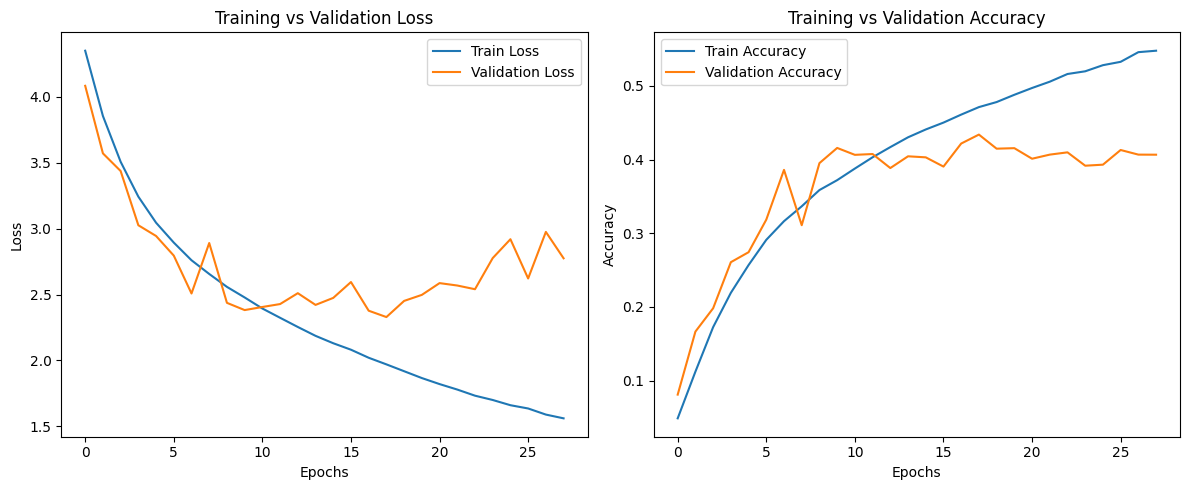

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion matrix on the test set

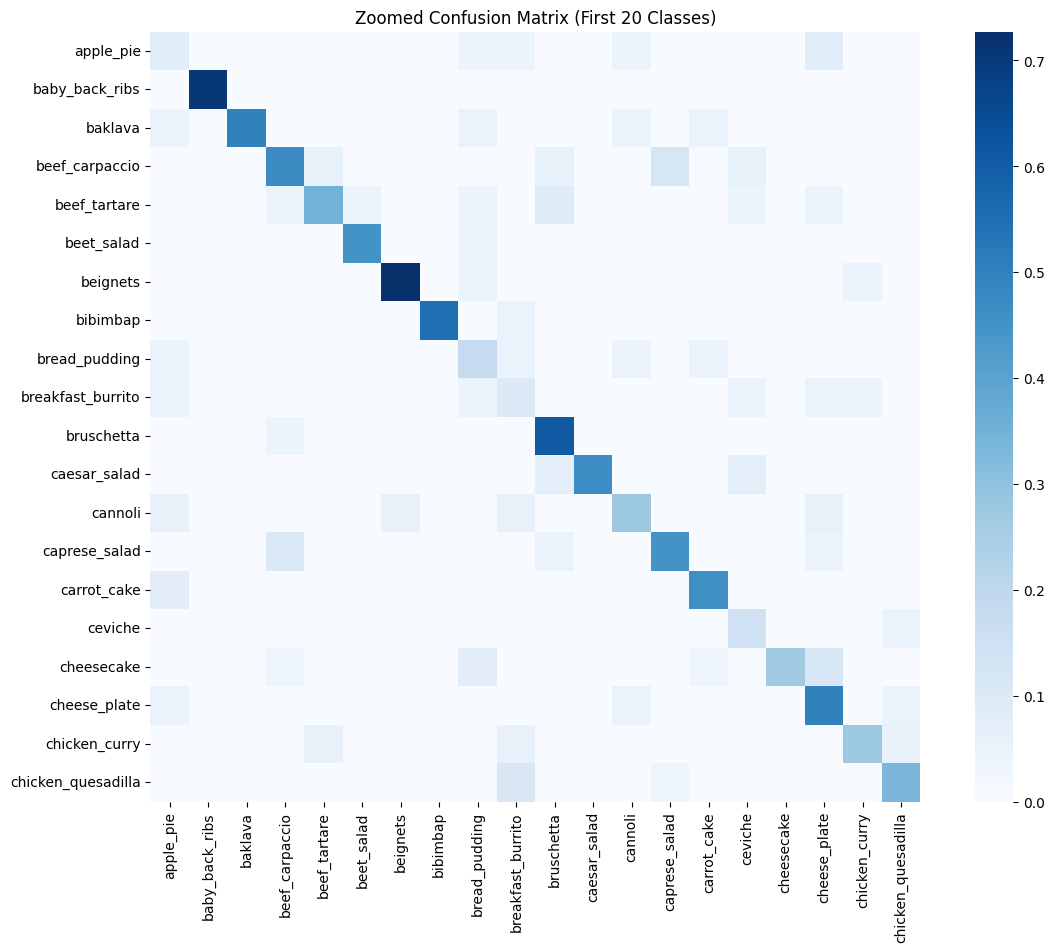

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# choose first 20 classes for zoomed view
CLASS_COUNT = 20

cm_small = cm[:CLASS_COUNT, :CLASS_COUNT]
labels_small = food_label_names[:CLASS_COUNT]

plt.figure(figsize=(14, 10))
sns.heatmap(
    cm_small,
    xticklabels=labels_small,
    yticklabels=labels_small,
    cmap="Blues",
    square=True,
    cbar=True
)

plt.title("Zoomed Confusion Matrix (First 20 Classes)")
plt.xticks(rotation=90)
plt.show()


# Dataset - Specific Evaluation

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# F1/precision/recall table
report = classification_report(
    y_true,
    y_pred,
    target_names=food_label_names,
    output_dict=True
)

# Convert to dataframe for readability
report_df = pd.DataFrame(report).transpose()


dataset_eval = report_df.iloc[:-3]

dataset_eval.head(15)  # first 15 classes


precision    recall  f1-score  support
apple_pie           0.118919  0.114583  0.116711    192.0
baby_back_ribs      0.460905  0.571429  0.510251    196.0
baklava             0.555556  0.440415  0.491329    193.0
beef_carpaccio      0.722973  0.551546  0.625731    194.0
beef_tartare        0.641026  0.523560  0.576369    191.0
beet_salad          0.575472  0.312821  0.405316    195.0
beignets            0.729167  0.714286  0.721649    196.0
bibimbap            0.730159  0.476684  0.576803    193.0
bread_pudding       0.163636  0.184615  0.173494    195.0
breakfast_burrito   0.072917  0.071066  0.071979    197.0
bruschetta          0.334437  0.534392  0.411405    189.0
caesar_salad        0.675676  0.641026  0.657895    195.0
cannoli             0.540230  0.243523  0.335714    193.0
caprese_salad       0.419355  0.393939  0.406250    198.0
carrot_cake         0.405063  0.494845  0.445476    194.0

# Final Test Metrics

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("Final Test Metrics:")
print("--------------------")
print("Test Accuracy:", accuracy_score(y_true, y_pred))
print("Macro Precision:", precision_score(y_true, y_pred, average='macro'))
print("Macro Recall:", recall_score(y_true, y_pred, average='macro'))
print("Macro F1 Score:", f1_score(y_true, y_pred, average='macro'))


Final Test Metrics:
--------------------
Test Accuracy: 0.4293889229511547
Macro Precision: 0.4583905325844708
Macro Recall: 0.42957744584202456
Macro F1 Score: 0.43087134375839775
